In [141]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [142]:
import torch
import numpy as np
from blending.utils.dataset import ImageDataBlending
from blending.utils.image import (show_image, get_image_laplacian_operator, get_blending_gradients,
                                  get_mixing_gradients)
from blending.utils.plots import plots_multiple_image_data, plots_multiple_tensor_image
from blending import blend
from argparse import Namespace

In [143]:
opt = Namespace(
    data_dir = 'data_blending',
    normalize = True,
    requires_grad = True,
    device = 'cpu'
)

device = torch.device(opt.device)

# Load Data

In [145]:
image_data_blending = ImageDataBlending(opt.data_dir, normalize=opt.normalize, device=device)

Getting Files:   0%|          | 0/4 [00:00<?, ?it/s]

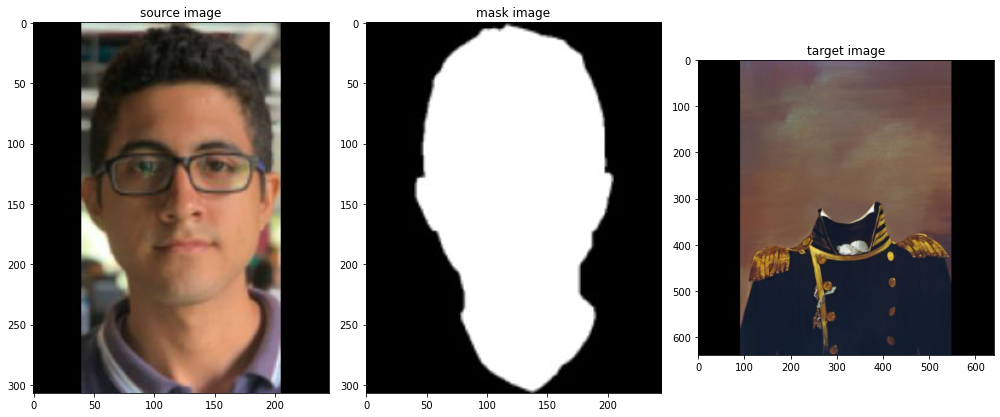

In [88]:
plots_multiple_image_data(image_data_blending[0], normalize=opt.normalize)

# Laplacian Operator

Laplacian operator $\nabla I$ over the image:

$$
\nabla = \begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix}
$$

In order to get the gradients of the images, we are going to define a convolutinal operation using the `laplacian matrix` as the kernel. Then make a convolution between the image, $I$, and the kernel $\nabla$

$$\begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix} \circledast I$$

The following code will calculate each channel's gradients, and present it as plots 

## Gradients of source image

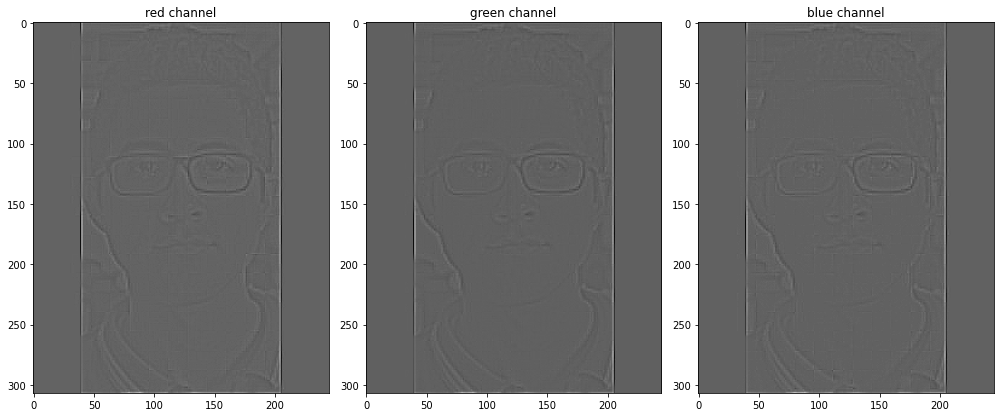

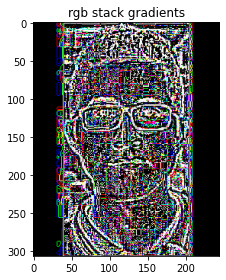

In [89]:
# Show each channel gradient
rgb_gradients = get_image_laplacian_operator(image_data_blending[0]['source'].unsqueeze(0))
plots_multiple_tensor_image(*rgb_gradients, title_name=["red channel", "green channel", "blue channel"],
                           normalize=opt.normalize)

# Show stack gradients just if normalize is false from the beginning
rgb_gradients = torch.stack(rgb_gradients, dim=2).view(*image_data_blending[0]['source'].shape)
plots_multiple_tensor_image(np.asarray(show_image(rgb_gradients)), title_name=["rgb stack gradients"],
                            figsize=(8, 4), normalize=opt.normalize)

## Gradients of target image

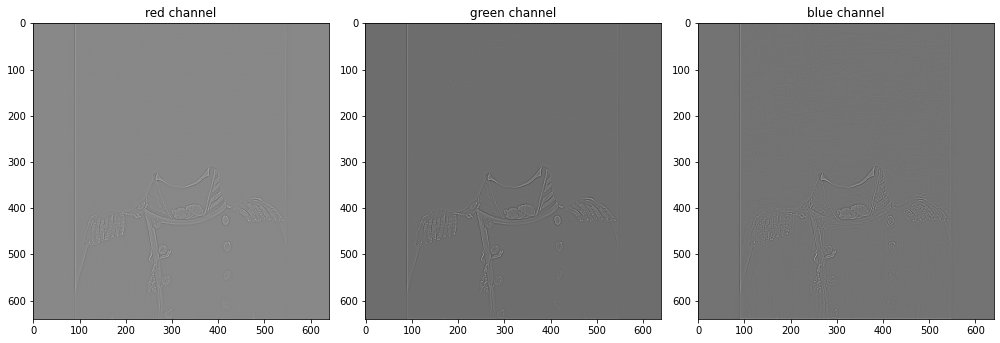

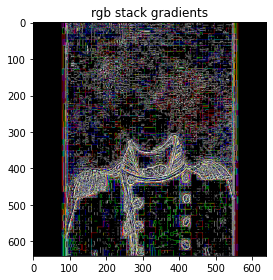

In [90]:
# Show each channel gradient
rgb_gradients = get_image_laplacian_operator(image_data_blending[0]['target'].unsqueeze(0))
plots_multiple_tensor_image(*rgb_gradients, title_name=["red channel", "green channel", "blue channel"],
                            normalize=opt.normalize)

# Show stack gradients
rgb_gradients = torch.stack(rgb_gradients, dim=2).view(*image_data_blending[0]['target'].shape)
plots_multiple_tensor_image(np.asarray(show_image(rgb_gradients)), title_name=["rgb stack gradients"],
                            figsize=(8, 4), normalize=opt.normalize)

# Join Gradients

As we are going to blend both images `source` and `target`, we need to mix its gradients in order to optimize the following loss function:

$$L_{grad} = \frac{1}{2HW} \sum_{m=1}^{H}\sum_{n=1}^{W}[\nabla f(I_B) - (\nabla f(I_S) + \nabla f(I_T)]^{2}_{mn}$$

where $f$ is the blending function, $\nabla$ the laplacian operator, $I_S$ the source image and $I_T$ the target image. This loss function is over the gradients that means we are going to create a image such that optimize the previous loss grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


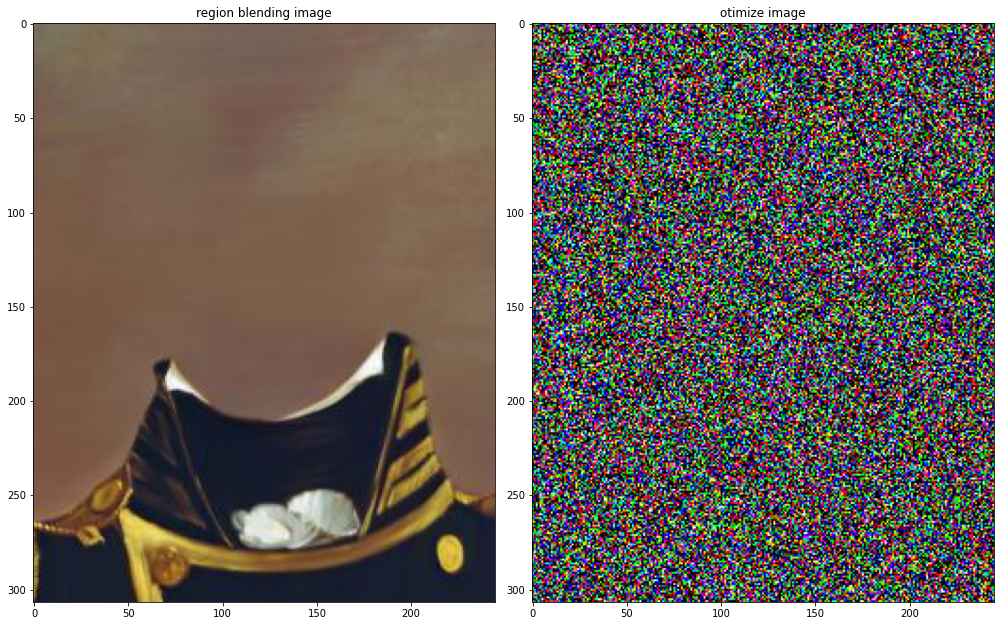

In [128]:
image_data = {
    'source': image_data_blending[0]['source'].unsqueeze(0),
    'target': image_data_blending[0]['target'].unsqueeze(0),
    'dims': image_data_blending[0]['dims'],
    'mask': image_data_blending[0]['mask'].unsqueeze(0)
}

dims = image_data['dims']
mask = image_data['mask']
input_img = torch.randn_like(image_data['source']).contiguous()
input_img.requires_grad = opt.requires_grad
tensor_image_target = image_data['target'][:, :, dims[0]:dims[1], dims[2]:dims[3]] 

# plot tensor image
with torch.no_grad():
    plots_multiple_tensor_image(tensor_image_target, input_img,
                                title_name=["region blending image",
                                            "otimize image"], normalize=opt.normalize)

optimizer = torch.optim.LBFGS([input_img.requires_grad_()], lr=1.5, max_iter=100)
mseLoss = torch.nn.MSELoss()
gt_gradients = torch.stack(get_mixing_gradients(image_data), dim=2).squeeze(0)

In [129]:
run = [0]
num_step = 100000
lg=1e7

while run[0] < num_step:
    def closure():
        optimizer.zero_grad()
        blend_img = (input_img * mask + tensor_image_target * (1 - mask))
        blend_gradients = torch.stack(get_blending_gradients(image_data, blend_img), dim=2).squeeze(0)
        grad_loss = lg*mseLoss(blend_gradients, gt_gradients)
        if run[0]%20 == 0:
            print("step: {}, grad_loss : {:.3f}".format(run[0], grad_loss.item()))
        run[0] += 1
        grad_loss.backward()
        return loss
    optimizer.step(closure)

step: 0, grad_loss : 90127896.000
step: 20, grad_loss : 218988.625
step: 40, grad_loss : 22613.520
step: 60, grad_loss : 6733.820
step: 80, grad_loss : 3087.605
step: 100, grad_loss : 1808.798
step: 120, grad_loss : 1185.059
step: 140, grad_loss : 801.445
step: 160, grad_loss : 594.149
step: 180, grad_loss : 449.582
step: 200, grad_loss : 332.703
step: 220, grad_loss : 263.826
step: 240, grad_loss : 218.846
step: 260, grad_loss : 185.982
step: 280, grad_loss : 162.771
step: 300, grad_loss : 140.744
step: 320, grad_loss : 122.904
step: 340, grad_loss : 108.211
step: 360, grad_loss : 94.765
step: 380, grad_loss : 90.480
step: 400, grad_loss : 77.196
step: 420, grad_loss : 69.943
step: 440, grad_loss : 63.480
step: 460, grad_loss : 58.391
step: 480, grad_loss : 53.842
step: 500, grad_loss : 50.267
step: 520, grad_loss : 46.710
step: 540, grad_loss : 43.655
step: 560, grad_loss : 40.796
step: 580, grad_loss : 38.113
step: 600, grad_loss : 36.735
step: 620, grad_loss : 33.823
step: 640, gra

## Results just using grad loss function

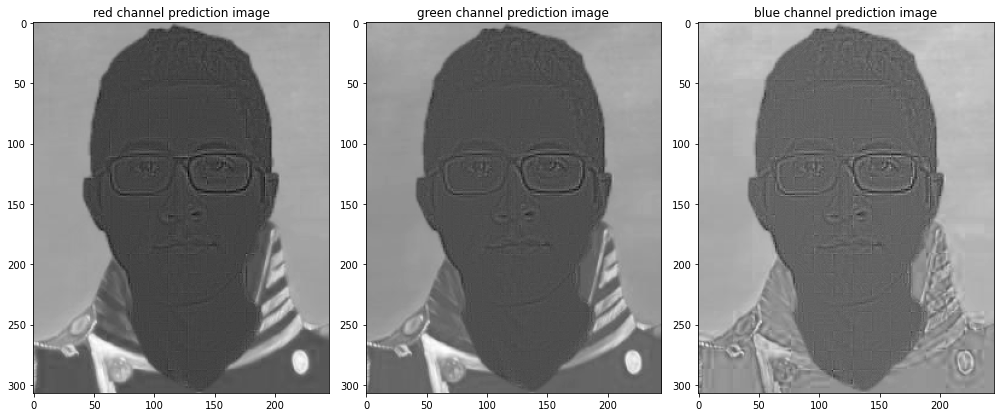

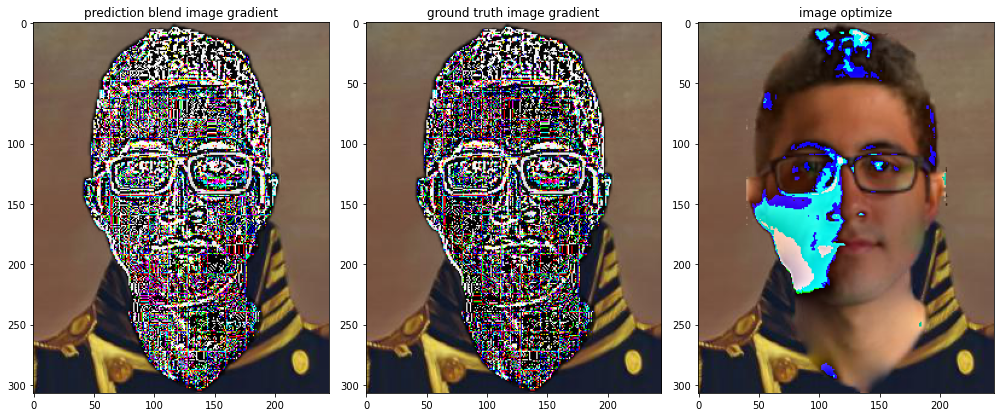

In [130]:
with torch.no_grad():
    blend_img = (input_img * mask + tensor_image_target * (1 - mask))
    blend_gradients = torch.stack(get_blending_gradients(image_data, blend_img), dim=2).squeeze(0)
    plots_multiple_tensor_image(*[blend_gradients[:, ch, :, :] for ch in range(3)],
                                title_name=["red channel prediction image",
                                           "green channel prediction image",
                                           "blue channel prediction image"], normalize=opt.normalize)
    plots_multiple_tensor_image(np.asarray(show_image(blend_gradients)),
                                np.asarray(show_image(gt_gradients)),
                                np.asarray(show_image(blend_img)), 
                                title_name=["prediction blend image gradient",
                                           "ground truth image gradient",
                                           "image optimize"], normalize=opt.normalize)

## Content loss function

this content loss function 